In [22]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

dfp_mapping_train = pd.read_csv("./data/train_breath_mapping.csv")

In [2]:
folder = "./data/updated_datasets/"
column_target = "pressure"
columns_features = ["R-C", "max_u_in", "min_u_in", "u_in_norm", "u_in_norm_trend", "u_out", "u_out_threshold_reached", "time_step"]

In [3]:
dfp_train_full = pd.read_csv(folder + "train_20211004.csv")
dfp_test = pd.read_csv(folder + "test_20211004.csv")

In [4]:
dfp_train = pd.merge(dfp_train_full, dfp_mapping_train[dfp_mapping_train["type_record"] == "training"][["breath_id"]], on=["breath_id"])
dfp_validation = pd.merge(dfp_train_full, dfp_mapping_train[dfp_mapping_train["type_record"] == "validation"][["breath_id"]], on=["breath_id"])

In [9]:
# Get the sample for the clustering
dfp_clustering_breath_id = dfp_mapping_train[dfp_mapping_train["type_record"] == "training"].sort_values(["breath_id"]).sample(frac=0.1, random_state=12)

In [10]:
column = "u_in_norm"
X = []
for breath_id in tqdm(sorted(dfp_clustering_breath_id["breath_id"].unique().tolist())):
    dfp_data_breath_id = dfp_train[dfp_train["breath_id"] == breath_id]
    X.append(dfp_data_breath_id[column].tolist())

100%|██████████| 6036/6036 [00:22<00:00, 263.17it/s]


## Build projection with ED

In [17]:
%%time
euclidean_distance_X = euclidean_distances(X, X)
embedding = MDS(n_components=2, dissimilarity="precomputed", random_state=12)
projection_X = embedding.fit_transform(euclidean_distance_X)

CPU times: user 28min 22s, sys: 2min 55s, total: 31min 17s
Wall time: 8min 38s


In [18]:
projection_X[:,0]

array([-0.27187435, -2.04825276,  0.92623935, ..., -0.11816943,
       -1.70293922, -2.27348004])

In [19]:
dfp_projection = pd.DataFrame({
    "breath_id" : sorted(dfp_clustering_breath_id["breath_id"].unique().tolist()),
    "x" : projection_X[:,0],
    "y" : projection_X[:,1] 
})

In [20]:
dfp_projection.iloc[0]

breath_id    41.000000
x            -0.271874
y            -1.845079
Name: 0, dtype: float64

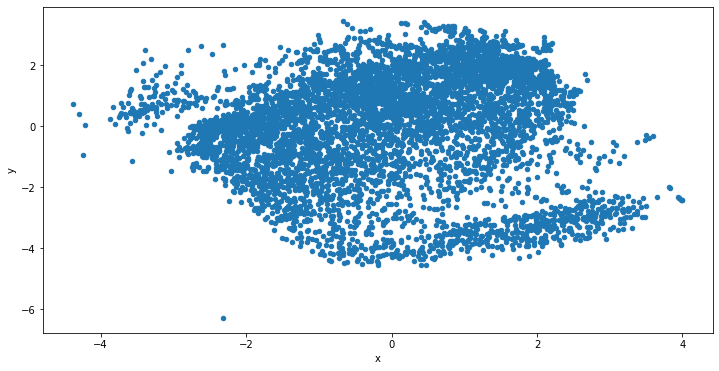

In [24]:
fig,ax=plt.subplots(figsize=(12,6))
dfp_projection.plot(ax=ax, x="x", y="y", kind="scatter")
plt.show()

## Build projection with DTW

In [27]:
from dtaidistance import dtw
import numpy as np

dtw_X = dtw.distance_matrix_fast(np.array(X))

In [28]:
embedding_dtw = MDS(n_components=2, dissimilarity="precomputed", random_state=12)
projection_X_dtw = embedding_dtw.fit_transform(dtw_X)

In [29]:
dfp_projection_dtw = pd.DataFrame({
    "breath_id" : sorted(dfp_clustering_breath_id["breath_id"].unique().tolist()),
    "x" : projection_X_dtw[:,0],
    "y" : projection_X_dtw[:,1] 
})

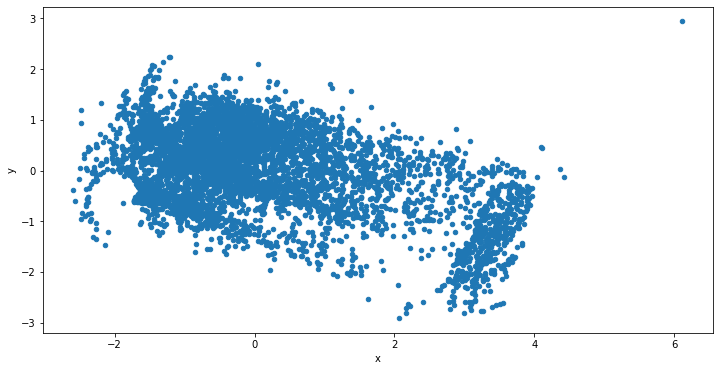

In [30]:
fig,ax=plt.subplots(figsize=(12,6))
dfp_projection_dtw.plot(ax=ax, x="x", y="y", kind="scatter")
plt.show()

## Build some clustering now

In [31]:
from sklearn.cluster import DBSCAN

In [32]:
clustering_euclidian_distance = DBSCAN(eps=3, min_samples=2).fit(projection_X)

In [36]:
clustering_euclidian_distance.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
np.unique(clustering_euclidian_distance.labels_)

array([0])

In [39]:
clustering_dtw = DBSCAN(eps=3, min_samples=2).fit(projection_X_dtw)

In [40]:
np.unique(clustering_dtw.labels_)

array([-1,  0])

In [43]:
from dtaidistance import clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
cluster_idx = model1.fit(np.array(X))

100%|█████████▉| 6035/6036 [11:04<00:00,  9.01it/s]

In [44]:
dfp_clusters = pd.DataFrame({
    "breath_id" : sorted(dfp_clustering_breath_id["breath_id"].unique().tolist()),
    "cluster_model1" : cluster_idx
})

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

In [46]:
cluster_idx.keys()

dict_keys([0])